In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time

# Load models

In [51]:
env_name = "ShaftInsertion/"
model_name = "MHGP-BDI/"
iter = "0/3/"

lnr_path = "/Users/hanbit-o/code/Visualization_wall_avoidance_results/Data/Result/" + env_name + model_name + iter + "learner.pickle"
# lnr_path = "/Users/hanbit-o/code/Visualization_wall_avoidance_results/Data/Result/ShaftInsertion/20211116_BDI_shaft_insertion/learner.pickle"
# lnr_path = "/Users/hanbit-o/code/Visualization_wall_avoidance_results/Data/Result/ShaftInsertion/20211115_BDI_shaft_insertion/MHGP-BDI/0/1/learner.pickle"

lnr_path = "/Users/hanbit-o/code/Visualization_wall_avoidance_results/Data/Result/ShaftInsertion/20211116_BDI_shaft_insertion/3/MHGP-BDI/0/1/learner.pickle"
lnr = torch.load(lnr_path)
learner = lnr["learner"]

## state
relative coordinations
- S: shaft
- G: gripper
- State = [(S-G1)[X,Y,Z], (S-G2)[X,Y,Z]]
    - X: horizontal left-right
    - Y: horizontal up-down
    - Z: vertical up-down

In [52]:
# Starting point of end effector
    # (end-effector)
    #     x: -0.5909129532489867
    #     y: 0.39471475958372093
    #     z: 0.39175792915985286
    # (shaftC)
    #     x: -0.5918293595314026
    #     y: 0.3821650743484497
    #     z: 0.3343000113964081
starting_position_Sc = np.array([-0.592, 0.382, 0.334])
holeA_position = lnr["learner"].X[0][:3] + starting_position_Sc
holeB_position = lnr["learner"].X[0][3:6] + starting_position_Sc

shaftC_position = holeA_position - lnr["learner"].X[0][:3]
print("HoleA: ",holeA_position)
print("HoleB: ",holeB_position)

HoleA:  tensor([-0.5124,  0.2012,  0.0891], dtype=torch.float64)
HoleB:  tensor([-0.7055,  0.1937,  0.0899], dtype=torch.float64)


### Visualization area

- X-axis: shaft_A_x - 0.1[m] <= X <= shaft_A_x + 0.1[m]
- Y-axis: shaft_A_y
- Z-axis: shaft_A_z - 0.1[m] <= Z <= shaft_A_z + 0.4[m]

In [53]:
Ha_x, Ha_y, Ha_z = holeA_position
Hb_x, Hb_y, Hb_z = holeB_position
Sc_x, Sc_y, Sc_z = starting_position_Sc
scale = 1
x_range = np.array(-0.7)
y_range = np.array([Ha_y - 0.1*scale, Ha_y + 0.30*scale])
z_range = np.array([Ha_z - 0.1*scale, Ha_z + 0.55*scale])


In [54]:
print("X: ", x_range)
print("Y: ", y_range)
print("Z: ", z_range)
print("Hole A: ", holeA_position)
print("Hole B: ", holeB_position)

X:  -0.7
Y:  [0.10120767 0.50120767]
Z:  [-0.01086837  0.63913163]
Hole A:  tensor([-0.5124,  0.2012,  0.0891], dtype=torch.float64)
Hole B:  tensor([-0.7055,  0.1937,  0.0899], dtype=torch.float64)


In [55]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time

In [56]:
def get_traj_fig(dir_fig=str, fig_name=str):
    # No grid line 
    plt.grid(color = 'grey',alpha=0.1)
    # plt.grid(color = 'grey',alpha=0.0)
    # back ground image
    im = plt.imread("Data/Figures/shaft_insertion_env_v1.png")
    plt.imshow(im, extent=[y_range[0],y_range[1], z_range[0],z_range[1]],alpha=1.0)

    xticks = torch.linspace(float(y_range[0]),float(y_range[1]), steps=3)
    xticks = np.around(xticks.numpy(),decimals=2)
    zticks = torch.linspace(float(z_range[0]),float(z_range[1]), steps=3)
    zticks = np.around(zticks.numpy(),decimals=2)

    plt.xticks(xticks,alpha=1.0)
    plt.yticks(zticks,alpha=1.0)
    plt.xlabel("Y",fontsize=15,labelpad=1)
    plt.ylabel("Z",fontsize=15, labelpad=1)
    plt.savefig(dir_fig + fig_name + '_v1.png',transparent=True)
    # plt.savefig(dir_fig + fig_name + '.pdf')

def get_dpoints_plt(dataset, color="b"):
    """dataset = [N , 2]"""
    # X, Y = dataset[:,0], dataset[:,1]
    X, Y = dataset[:,0][::3], dataset[:,1][::3]
    plt.scatter(X, Y, c=color, s=100, alpha=0.1, marker = 's')

## 3D-scatter datapoints

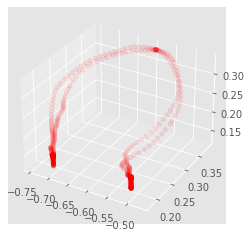

In [57]:
States = learner.X

dataPoints = -(States[:,:3]-holeA_position)
xs, ys, zs = dataPoints[:,0], dataPoints[:,1], dataPoints[:,2]
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs=xs, ys=ys, zs=zs, marker='o', alpha =0.1, color='r')

## Heat-map of disturbance level

### Dummy data: end-effctor position -> state
- state: 
    - [0:3] HoleA - shaftC
    - [3:6] HoleB - shaftC

In [133]:
# make these smaller to increase the resolution
res = 0.007
# generate 2 2d grids for the x & y bounds
Y, X = np.mgrid[slice(z_range[0],z_range[1] + res, res),
                slice(y_range[0],y_range[1] + res, res)]

Sc_positions = torch.tensor(np.vstack((X.flatten(), Y.flatten())).T)

state1 = torch.stack((Ha_x.repeat(Sc_positions.shape[0])-x_range,
        Ha_y - Sc_positions[:,0],
        Ha_z - Sc_positions[:,1])).T
state2 = torch.stack((Hb_x.repeat(Sc_positions.shape[0])-x_range,
        Hb_y - Sc_positions[:,0],
        Hb_z - Sc_positions[:,1])).T
S = torch.cat((state1,state2),axis=1)

_,_, disturbance = learner.predict(S)

# D = (disturbance **2).sum(1).sqrt()
D = disturbance.mean(1)

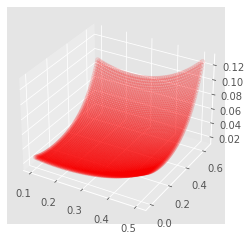

In [134]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs=x, ys=y, zs=z, marker='o', alpha =0.1, color='r')

(94, 59)
Z-MIN:  tensor(0.0094)


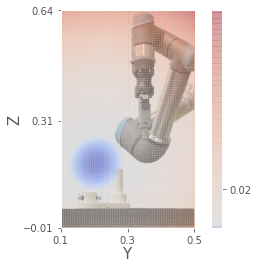

In [139]:
print(X.shape)
x, y, z = X, Y, D.view(X.shape)
# cmap_min = 0.02
# cmap_min = 0.015
# cmap_max = 0.02
cmap_min = z.min()
cmap_max = z.max()
print("Z-MIN: ",cmap_min)
import matplotlib.colors as colors
# c = plt.pcolormesh(x, y, z, cmap='bwr', vmin=0.015, vmax=0.03,alpha=0.2,shading='gouraud')
# c = plt.pcolormesh(x, y, z, cmap='coolwarm', vmin=cmap_min, vmax=cmap_max, alpha=0.2,shading='gouraud')
# c = plt.pcolormesh(x, y, z, cmap='coolwarm', alpha=0.2,shading='gouraud',norm=colors.LogNorm(vmin=z.min(), vmax=z.max()))
# c = plt.pcolormesh(x, y, z, cmap='coolwarm', alpha=0.2,shading='gouraud',norm=colors.SymLogNorm(linthresh=0.01, linscale=1000.0,
#                                               vmin=z.min(), vmax=z.max(), base=10))
# c = plt.pcolormesh(x, y, z, cmap='coolwarm', alpha=0.2,shading='gouraud',norm=colors.PowerNorm(gamma=0.2, vmin=z.min(), vmax=z.max()))

# Normalize data with a set center.
# since hole diameter is 0.02[m],  vcenter is 0.02[m] 
divnorm = colors.TwoSlopeNorm(vmin=z.min(), vcenter=0.01, vmax=z.max())
c = plt.pcolormesh(x, y, z, cmap='coolwarm', alpha=0.2,shading='gouraud',norm=divnorm)


# c = plt.pcolormesh(x, y, z, cmap='brg', vmin=0.02, vmax=0.1,alpha=0.2,shading='gouraud')
# c = plt.pcolormesh(x, y, z, cmap='bwr', alpha=0.2,shading='gouraud')
cmap_ticks = np.linspace(cmap_min,cmap_max,3)
cmap_ticks = np.around(cmap_ticks, decimals=3)
# cbar = plt.colorbar(c, ticks=cmap_ticks)
cbar = plt.colorbar(c,ticks=[0.02,0.07,0.12])

# fig, ax = plt.subplots()
# cax = ax.pcolormesh(x, y, z, cmap='coolwarm', vmin=cmap_min, vmax=cmap_max, alpha=0.2,shading='gouraud')
# cbar = fig.colorbar(c, ticks=[-1, 0, 1])
# cbar = plt.colorbar(c, ticks=cmap_ticks)
# cbar.ax.set_yticklabels([cmap_ticks[0], '0', '> 1'])

get_traj_fig(dir_fig="Data/Result/Disturbance_visualization/Disturbance_map/shaft_insertion/", fig_name='state_dependent'+ str(int(time.time())) )

In [60]:
env_name = "ShaftInsertion/"
model_name = "MGP-BDI/"
iter = "0/1/"

lnr_path = "/Users/hanbit-o/code/Visualization_wall_avoidance_results/Data/Result/" + env_name + model_name + iter + "learner.pickle"
homo = torch.load(lnr_path)
homo_lnr = homo["learner"]
homo_noise = (np.exp(homo_lnr.log_sigma[len(homo_lnr.K) - 1]))
print(homo_noise)
homo_noise_level = (homo_noise **2).sum(0).sqrt()
print(homo_noise_level)

tensor([0.2078, 0.2074, 0.2076])
tensor(0.3596)


(94, 59)


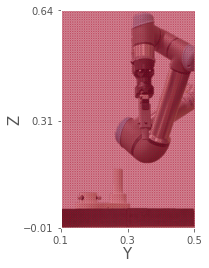

In [128]:
# x, y, z = X, Y, D.view(41,41)
print(X.shape)
x, y, z = X, Y, D.view(X.shape)
z = z/abs(z)
z *= homo_noise_level

# Normalize data with a set center.
# since hole diameter is 0.02[m],  vcenter is 0.02[m] 
divnorm = colors.TwoSlopeNorm(vmin=cmap_min, vcenter=0.02, vmax=cmap_max)
c = plt.pcolormesh(x, y, z, cmap='coolwarm', alpha=0.2,shading='gouraud',norm=divnorm)

# c = plt.pcolormesh(x, y, z, cmap='coolwarm', vmin=0.0, vmax=1.5, alpha=0.6)
# c = plt.pcolormesh(x, y, z, cmap='bwr', vmin=cmap_min, vmax=cmap_max, alpha=0.2,shading='gouraud')
# c = plt.pcolormesh(x, y, z, cmap='coolwarm', vmin=cmap_min, vmax=cmap_max, alpha=0.2,shading='gouraud')
# c = plt.pcolormesh(x, y, z, cmap='Reds', vmin=0.0, vmax=1.5, alpha=0.6)

# plt.colorbar(c)

get_traj_fig(dir_fig="Data/Result/Disturbance_visualization/Disturbance_map/shaft_insertion/", fig_name='state_independent'+ str(int(time.time())) )